In [ ]:
#VAEP functions are compatible with this version of the socceraction library only

!pip install socceraction==0.2.0

In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile

import json
import pandas as pd

import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep.formula import value

from sklearn.metrics import brier_score_loss, roc_auc_score
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [3]:
data_files = {
    'events': 'https://ndownloader.figshare.com/files/14464685',  # ZIP file containing one JSON file for each competition
    'matches': 'https://ndownloader.figshare.com/files/14464622',  # ZIP file containing one JSON file for each competition
    'players': 'https://ndownloader.figshare.com/files/15073721',  # JSON file
    'teams': 'https://ndownloader.figshare.com/files/15073697'  # JSON file
}

In [4]:
for url in tqdm(data_files.values()):
    url_s3 = urlopen(url).geturl()
    path = Path(urlparse(url_s3).path)
    file_name = path.name
    file_local, _ = urlretrieve(url_s3, file_name)
    if is_zipfile(file_local):
        with ZipFile(file_local) as zip_file:
            zip_file.extractall()

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [6]:
json_teams = read_json_file('teams.json')
df_teams = pd.read_json(json_teams)

In [7]:
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [8]:
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')

In [9]:
json_players = read_json_file('players.json')
df_players = pd.read_json(json_players)

In [10]:
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


In [11]:
df_players.to_hdf('wyscout.h5', key='players', mode='a')

In [12]:
competitions = [
    'England',
#     'France',
#     'Germany',
#     'Italy',
#    'Spain',
#   'European Championship',
#   'World Cup'
]

In [13]:
dfs_matches = []
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)
df_matches = pd.concat(dfs_matches)

In [14]:
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364
5,Played,4405654,38,"{'1613': {'scoreET': 0, 'coachId': 210700, 'si...",181150,2018-05-13 14:00:00,1613,St. James' Park,2500094,"Newcastle United - Chelsea, 3 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384888, 'role': 'referee'}, {'r...",Regular,364
6,Played,4405654,38,"{'1625': {'scoreET': 0, 'coachId': 267136, 'si...",181150,2018-05-13 14:00:00,1625,St. Mary's Stadium,2500095,"Southampton - Manchester City, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364
7,Played,4405654,38,"{'10531': {'scoreET': 0, 'coachId': 32573, 'si...",181150,2018-05-13 14:00:00,1639,Liberty Stadium,2500096,"Swansea City - Stoke City, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378952, 'role': 'referee'}, {'r...",Regular,364
8,Played,4405654,38,"{'1631': {'scoreET': 0, 'coachId': 209010, 'si...",181150,2018-05-13 14:00:00,1624,Wembley Stadium,2500097,"Tottenham Hotspur - Leicester City, 5 - 4","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378951, 'role': 'referee'}, {'r...",Regular,364
9,Played,4405654,38,"{'1623': {'scoreET': 0, 'coachId': 8541, 'side...",181150,2018-05-13 14:00:00,1633,London Stadium,2500098,"West Ham United - Everton, 3 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364


In [15]:
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')

In [16]:
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(file_events)
    df_events = pd.read_json(json_events)
    df_events_matches = df_events.groupby('matchId', as_index=False)
    for match_id, df_events_match in df_events_matches:
        df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

In [17]:
convert_to_spadl('wyscout.h5', 'spadl.h5')

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████████████████████████████████████████████████████████████████████████| 380/380 [00:42<00:00,  8.95game/s]


...Converting events to actions


100%|██████████████████████████████████████████████████████████████████████████████| 380/380 [03:52<00:00,  1.64game/s]


In [18]:
df_games = pd.read_hdf('spadl.h5', key='games')
df_actiontypes = pd.read_hdf('spadl.h5', key='actiontypes')
df_bodyparts = pd.read_hdf('spadl.h5', key='bodyparts')
df_results = pd.read_hdf('spadl.h5', key='results')

In [19]:
nb_prev_actions = 3

In [20]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

In [21]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    dfs_gamestates = features.gamestates(df_actions, nb_prev_actions=nb_prev_actions)
    dfs_gamestates = features.play_left_to_right(dfs_gamestates, game['home_team_id'])
    
    df_features = pd.concat([function(dfs_gamestates) for function in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [22]:
functions_labels = [
    labels.scores,
    labels.concedes
]

In [23]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .reset_index(drop=True)
    )
    
    df_labels = pd.concat([function(df_actions) for function in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [24]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=nb_prev_actions)

In [25]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [26]:
df_features.head(10)

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,63.091679,0.053916,63.091679,0.053916,63.091679,0.053916,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,68.328929,0.355773,63.091679,0.053916,63.091679,0.053916,True,True,1.997756,1.997756
2,True,False,False,False,False,False,False,False,False,False,...,73.715416,0.185556,68.328929,0.355773,63.091679,0.053916,True,True,0.771744,2.769500
3,True,False,False,False,False,False,False,False,False,False,...,38.707772,0.396818,73.715416,0.185556,68.328929,0.355773,True,True,2.174464,2.946208
4,True,False,False,False,False,False,False,False,False,False,...,37.425928,0.620467,38.707772,0.396818,73.715416,0.185556,True,True,3.907382,6.081846
5,True,False,False,False,False,False,False,False,False,False,...,30.729141,1.258205,37.425928,0.620467,38.707772,0.396818,True,True,3.758730,7.666112
6,False,True,False,False,False,False,False,False,False,False,...,8.400000,0.000000,30.729141,1.258205,37.425928,0.620467,True,True,2.210584,5.969314
7,False,False,False,False,False,False,False,False,False,False,...,106.094842,0.246030,96.600000,0.000000,99.923872,0.296969,False,False,1.756122,3.966706
8,False,True,False,False,False,False,False,False,False,False,...,25.925192,1.489705,25.925192,1.489705,8.400000,0.000000,False,True,2.095783,3.851905
9,False,False,False,False,False,False,False,False,False,False,...,89.647658,0.388999,106.094842,0.246030,106.094842,0.246030,False,True,3.034782,5.130565


In [27]:
columns_labels = [
    'scores',
    'concedes'
]

In [28]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [29]:
df_labels.head(10)

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


In [30]:
%%time
models = {}
for column_labels in columns_labels:
    model = CatBoostClassifier(
        eval_metric='AUC')
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

Learning rate set to 0.144289
0:	total: 341ms	remaining: 5m 40s
1:	total: 472ms	remaining: 3m 55s
2:	total: 602ms	remaining: 3m 19s
3:	total: 729ms	remaining: 3m 1s
4:	total: 875ms	remaining: 2m 54s
5:	total: 1.02s	remaining: 2m 48s
6:	total: 1.15s	remaining: 2m 43s
7:	total: 1.29s	remaining: 2m 39s
8:	total: 1.43s	remaining: 2m 38s
9:	total: 1.56s	remaining: 2m 34s
10:	total: 1.72s	remaining: 2m 34s
11:	total: 1.86s	remaining: 2m 33s
12:	total: 2.01s	remaining: 2m 32s
13:	total: 2.15s	remaining: 2m 31s
14:	total: 2.31s	remaining: 2m 31s
15:	total: 2.45s	remaining: 2m 30s
16:	total: 2.58s	remaining: 2m 29s
17:	total: 2.71s	remaining: 2m 27s
18:	total: 2.85s	remaining: 2m 27s
19:	total: 2.98s	remaining: 2m 26s
20:	total: 3.13s	remaining: 2m 25s
21:	total: 3.26s	remaining: 2m 24s
22:	total: 3.4s	remaining: 2m 24s
23:	total: 3.53s	remaining: 2m 23s
24:	total: 3.67s	remaining: 2m 23s
25:	total: 3.81s	remaining: 2m 22s
26:	total: 3.94s	remaining: 2m 22s
27:	total: 4.07s	remaining: 2m 21s
28

In [31]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [32]:
df_predictions.head(10)

,scores,concedes
0,0.001790,0.000175
1,0.003614,0.001049
2,0.003609,0.001885
3,0.009227,0.002348
4,0.013203,0.001484
5,0.018766,0.001209
6,0.012525,0.002400
7,0.001365,0.017993
8,0.009803,0.001529
9,0.001607,0.003506


In [33]:
dfs_game_ids = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [34]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)

In [35]:
df_predictions.head(10)

,scores,concedes,game_id
0,0.001790,0.000175,2500089
1,0.003614,0.001049,2500089
2,0.003609,0.001885,2500089
3,0.009227,0.002348,2500089
4,0.013203,0.001484,2500089
5,0.018766,0.001209,2500089
6,0.012525,0.002400,2500089
7,0.001365,0.017993,2500089
8,0.009803,0.001529,2500089
9,0.001607,0.003506,2500089


In [36]:
df_predictions_per_game = df_predictions.groupby('game_id')

In [37]:
for game_id, df_predictions in tqdm(df_predictions_per_game):
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [38]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [39]:
dfs_values = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    df_actions = (df_actions
        .merge(df_actiontypes, how='left')
        .merge(df_results, how='left')
        .merge(df_bodyparts, how='left')
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values = value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

  0%|          | 0/380 [00:00<?, ?it/s]

In [40]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [41]:
df_actions

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name
0,2499719.0,1.0,2.758649,1609.0,25413.0,51.45,34.68,32.55,14.96,0,...,1,pass,success,foot,A. Lacazette,Alexandre,Lacazette,1991-05-28,Arsenal,Arsenal FC
1,2499719.0,1.0,4.946850,1609.0,370224.0,32.55,14.96,53.55,17.00,0,...,1,pass,success,foot,R. Holding,Rob,Holding,1995-09-20,Arsenal,Arsenal FC
2,2499719.0,1.0,6.542188,1609.0,3319.0,53.55,17.00,36.75,19.72,1,...,1,pass,success,head,M. Özil,Mesut,Özil,1988-10-15,Arsenal,Arsenal FC
3,2499719.0,1.0,8.143395,1609.0,120339.0,36.75,19.72,43.05,3.40,1,...,1,pass,success,head,Mohamed Elneny,Mohamed Naser,Elsayed Elneny,1992-07-11,Arsenal,Arsenal FC
4,2499719.0,1.0,10.302366,1609.0,167145.0,43.05,3.40,75.60,8.16,0,...,1,pass,success,foot,Bellerín,Héctor,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,2499719.0,2.0,2990.768201,1631.0,8653.0,93.45,46.24,97.65,36.04,0,...,1,pass,success,foot,H. Maguire,Harry,Maguire,1993-03-05,Leicester City,Leicester City FC
1284,2499719.0,2.0,2992.491575,1631.0,8480.0,97.65,36.04,56.70,33.32,0,...,0,pass,fail,foot,K. Schmeichel,Kasper,Schmeichel,1986-11-05,Leicester City,Leicester City FC
1285,2499719.0,2.0,2994.900590,1609.0,49876.0,56.70,33.32,76.65,28.56,1,...,1,pass,success,head,G. Xhaka,Granit,Xhaka,1992-09-27,Arsenal,Arsenal FC
1286,2499719.0,2.0,2997.086392,1609.0,7870.0,76.65,28.56,105.00,27.20,0,...,0,shot,fail,foot,A. Ramsey,Aaron,Ramsey,1990-12-26,Arsenal,Arsenal FC


In [42]:
df_values[
    ['short_name','team_name' , 'scores', 'concedes', 'offensive_value', 'defensive_value', 'vaep_value']
].head(10)

,short_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,A. Lacazette,Arsenal FC,0.001707,0.000053,0.000000,-0.000000,0.000000
1,R. Holding,Arsenal FC,0.006638,0.001194,0.004930,-0.001141,0.003790
2,M. Özil,Arsenal FC,0.006537,0.000750,-0.000101,0.000443,0.000343
3,Mohamed Elneny,Arsenal FC,0.006277,0.001783,-0.000260,-0.001033,-0.001293
4,Bellerín,Arsenal FC,0.009461,0.001866,0.003184,-0.000083,0.003101
5,M. Özil,Arsenal FC,0.007010,0.001250,-0.002451,0.000617,-0.001834
6,H. Maguire,Leicester City FC,0.004925,0.004110,0.003675,0.002900,0.006575
7,Bellerín,Arsenal FC,0.007509,0.000897,0.003399,0.004028,0.007426
8,Bellerín,Arsenal FC,0.009972,0.000701,0.002463,0.000197,0.002660
9,G. Xhaka,Arsenal FC,0.005815,0.001476,-0.004157,-0.000775,-0.004933


In [43]:
df_values.head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,2499719.0,1.0,2.758649,1609.0,25413.0,51.45,34.68,32.55,14.96,0,...,Alexandre,Lacazette,1991-05-28,Arsenal,Arsenal FC,0.001707,0.000053,0.000000,-0.000000,0.000000
1,2499719.0,1.0,4.946850,1609.0,370224.0,32.55,14.96,53.55,17.00,0,...,Rob,Holding,1995-09-20,Arsenal,Arsenal FC,0.006638,0.001194,0.004930,-0.001141,0.003790
2,2499719.0,1.0,6.542188,1609.0,3319.0,53.55,17.00,36.75,19.72,1,...,Mesut,Özil,1988-10-15,Arsenal,Arsenal FC,0.006537,0.000750,-0.000101,0.000443,0.000343
3,2499719.0,1.0,8.143395,1609.0,120339.0,36.75,19.72,43.05,3.40,1,...,Mohamed Naser,Elsayed Elneny,1992-07-11,Arsenal,Arsenal FC,0.006277,0.001783,-0.000260,-0.001033,-0.001293
4,2499719.0,1.0,10.302366,1609.0,167145.0,43.05,3.40,75.60,8.16,0,...,Héctor,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC,0.009461,0.001866,0.003184,-0.000083,0.003101
5,2499719.0,1.0,12.548934,1609.0,3319.0,75.60,8.16,80.85,17.00,0,...,Mesut,Özil,1988-10-15,Arsenal,Arsenal FC,0.007010,0.001250,-0.002451,0.000617,-0.001834
6,2499719.0,1.0,13.961228,1631.0,8653.0,80.85,17.00,64.05,10.20,1,...,Harry,Maguire,1993-03-05,Leicester City,Leicester City FC,0.004925,0.004110,0.003675,0.002900,0.006575
7,2499719.0,1.0,15.320341,1609.0,167145.0,70.35,13.60,70.35,13.60,0,...,Héctor,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC,0.007509,0.000897,0.003399,0.004028,0.007426
8,2499719.0,1.0,15.320341,1609.0,167145.0,70.35,13.60,61.95,26.52,1,...,Héctor,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC,0.009972,0.000701,0.002463,0.000197,0.002660
9,2499719.0,1.0,18.051875,1609.0,49876.0,61.95,26.52,47.25,37.40,1,...,Granit,Xhaka,1992-09-27,Arsenal,Arsenal FC,0.005815,0.001476,-0.004157,-0.000775,-0.004933


In [44]:
df_values["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    df_values[["player_id","team_name", "vaep_value", "offensive_value", "defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)

In [45]:
# Add player names
playersR = playersR.merge(df_players[["player_id", "short_name"]], how="left")
playersR["player_name"] = playersR[["short_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
392,120353.0,Mohamed Salah,21.642914,22.214273,-0.571359,1568
325,38021.0,K. De Bruyne,18.393078,19.231434,-0.838356,3528
313,26150.0,R. Mahrez,18.379605,18.541025,-0.161420,2022
300,25707.0,E. Hazard,15.172472,15.231148,-0.058676,1974
4,54.0,C. Eriksen,14.645477,15.045624,-0.400147,2959
185,8717.0,H. Kane,14.456437,15.285209,-0.828772,1153
140,8317.0,David Silva,13.856882,13.881468,-0.024586,2925
27,3319.0,M. Özil,12.669707,14.083685,-1.413978,2278
333,49872.0,X. Shaqiri,12.308793,13.273822,-0.965029,1722
33,3350.0,Fàbregas,11.803279,11.423288,0.379991,2592


In [46]:
pg = pd.read_hdf('spadl.h5', "player_games")
pg = pg[pg.game_id.isin(df_games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 1710] # at least two full games played

def round_two_places(val):
    return round(val, 4)

stats["vaep_rating"] = (stats.vaep_value * 90 / stats.minutes_played).apply(round_two_places)
stats["offensive_rating"] = (stats.offensive_value * 90 / stats.minutes_played).apply(round_two_places)
stats["defensive_rating"] = (stats.defensive_value * 90 / stats.minutes_played).apply(round_two_places)
stats.sort_values("vaep_rating",ascending = False)

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
391,120353.0,Mohamed Salah,21.642914,22.214273,-0.571359,1568,2996.529579,0.6500,0.6672,-0.0172
299,25707.0,E. Hazard,15.172472,15.231148,-0.058676,1974,2505.438518,0.5450,0.5471,-0.0021
312,26150.0,R. Mahrez,18.379605,18.541025,-0.161420,2022,3063.065477,0.5400,0.5448,-0.0047
324,38021.0,K. De Bruyne,18.393078,19.231434,-0.838356,3528,3190.369684,0.5189,0.5425,-0.0236
26,3319.0,M. Özil,12.669707,14.083685,-1.413978,2278,2253.492156,0.5060,0.5625,-0.0565
...,...,...,...,...,...,...,...,...,...,...
294,25572.0,A. Ayew,0.015620,0.407675,-0.392054,807,1928.911229,0.0007,0.0190,-0.0183
127,8266.0,Gomes,-0.109478,2.454541,-2.564019,830,2238.454229,-0.0044,0.0987,-0.1031
186,8731.0,R. Shawcross,-0.323541,0.230366,-0.553906,975,2485.741393,-0.0117,0.0083,-0.0201
29,3327.0,Joselu,-0.267310,-0.424656,0.157346,750,1776.042698,-0.0135,-0.0215,0.0080


In [47]:
stats.to_csv('ranking.csv', index=False)

In [48]:
playersR.to_csv('ranking!.csv', index=False)

In [49]:
print(df_values['team_name'].unique())

['Arsenal FC' 'Leicester City FC' 'Manchester City FC'
 'Brighton & Hove Albion FC' 'Burnley FC' 'Chelsea FC' 'Crystal Palace FC'
 'Huddersfield Town FC' 'Everton FC' 'Stoke City FC'
 'Manchester United FC' 'West Ham United FC' 'Newcastle United FC'
 'Tottenham Hotspur FC' 'Swansea City AFC' 'Southampton FC' 'Watford FC'
 'Liverpool FC' 'West Bromwich Albion FC' 'AFC Bournemouth']


In [50]:
WB_team =df_values[(df_values["team_name"]== "Chelsea FC" ) | (df_values["team_name"]== "Arsenal FC" )| (df_values["team_name"]== "West Ham United FC" )]

In [51]:
WB_team

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
0,2499719.0,1.0,2.758649,1609.0,25413.0,51.45,34.68,32.55,14.96,0,...,Lacazette,1991-05-28,Arsenal,Arsenal FC,0.001707,0.000053,0.000000,-0.000000,0.000000,1
1,2499719.0,1.0,4.946850,1609.0,370224.0,32.55,14.96,53.55,17.00,0,...,Holding,1995-09-20,Arsenal,Arsenal FC,0.006638,0.001194,0.004930,-0.001141,0.003790,1
2,2499719.0,1.0,6.542188,1609.0,3319.0,53.55,17.00,36.75,19.72,1,...,Özil,1988-10-15,Arsenal,Arsenal FC,0.006537,0.000750,-0.000101,0.000443,0.000343,1
3,2499719.0,1.0,8.143395,1609.0,120339.0,36.75,19.72,43.05,3.40,1,...,Elsayed Elneny,1992-07-11,Arsenal,Arsenal FC,0.006277,0.001783,-0.000260,-0.001033,-0.001293,1
4,2499719.0,1.0,10.302366,1609.0,167145.0,43.05,3.40,75.60,8.16,0,...,Bellerín Moruno,1995-03-19,Arsenal,Arsenal FC,0.009461,0.001866,0.003184,-0.000083,0.003101,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483659,2500098.0,2.0,2783.137836,1633.0,8561.0,61.95,20.40,55.65,7.48,0,...,Noble,1987-05-08,West Ham United,West Ham United FC,0.010226,0.000590,-0.000685,0.000038,-0.000647,1
483660,2500098.0,2.0,2785.702032,1633.0,20620.0,55.65,7.48,103.95,19.04,0,...,Mba Obiang Avomo,1992-03-27,West Ham United,West Ham United FC,0.061898,0.002214,0.051671,-0.001623,0.050048,1
483661,2500098.0,2.0,2789.232666,1633.0,14703.0,103.95,19.04,103.95,19.04,0,...,Arnautović,1989-04-19,West Ham United,West Ham United FC,0.038429,0.004173,-0.023469,-0.001959,-0.025428,1
483663,2500098.0,2.0,2829.821084,1633.0,70965.0,105.00,0.00,92.40,36.04,0,...,Naval da Costa Eduardo,1993-01-19,West Ham United,West Ham United FC,0.021573,0.000538,-0.024927,-0.000538,-0.025465,1


In [52]:
print(WB_team['short_name'].unique().tolist())

['A. Lacazette', 'R. Holding', 'M. Özil', 'Mohamed Elneny', 'Bellerín', 'G. Xhaka', 'S. Kolašinac', 'Nacho Monreal', 'P. Čech', 'D. Welbeck', nan, 'A. Oxlade-Chamberlain', 'A. Ramsey', 'O. Giroud', 'T. Walcott', 'A. Rüdiger', 'Fàbregas', 'Azpilicueta', 'T. Courtois', 'Marcos Alonso', 'Willian', 'David Luiz', 'G. Cahill', 'N. Kanté', 'M. Batshuayi', 'J. Boga', 'A. Christensen', 'Álvaro Morata', 'Pedro Obiang', 'A. Ogbonna', 'M. Noble', 'E. Fernandes', 'A. Ayew', 'P. Zabaleta', 'A. Masuaku', 'J. Hart', 'J. Hernández', 'M. Arnautović', 'W. Reid', 'D. Sakho', 'D. Rice', 'A. Cresswell', 'S. Mustafi', 'A. Iwobi', 'V. Moses', 'T. Bakayoko', 'Pedro', 'C. Kouyaté', 'M. Antonio', 'João Mário', 'J. Hugill', 'J. Cullen', 'A. Sánchez', 'L. Koscielny', 'F. Coquelin', 'J. Collins', 'M. Lanzini', 'D. Zappacosta', 'E. Hazard', 'José Fonte', 'A. Carroll', 'C. Musonda', 'P. Mertesacker', 'J. Wilshere', 'D. Drinkwater', 'Adrián', 'E. Ampadu', 'A. Maitland-Niles', 'C. Chambers', 'R. Nelson', 'W. Caballero'

In [53]:
WBS = stats[(stats["player_name"]== "Bellerín" ) |(stats["player_name"]== "S. Kolašinac" ) |(stats["player_name"]== "A. Masuaku" )  | (stats["player_name"]== "P. Zabaleta" )|(stats["player_name"]== "V. Moses" ) | (stats["player_name"]== "Marcos Alonso" )   ] 
WBS

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
103,8032.0,Marcos Alonso,7.196683,6.652904,0.543779,2114,2973.092359,0.2179,0.2014,0.0165
137,8313.0,P. Zabaleta,4.281201,4.622848,-0.341648,2015,3435.489529,0.1122,0.1211,-0.0090
178,8625.0,V. Moses,4.694903,4.617123,0.077780,1466,2182.161945,0.1936,0.1904,0.0032
254,14869.0,S. Kolašinac,5.464388,5.241673,0.222715,1772,2233.897372,0.2202,0.2112,0.0090
314,26499.0,A. Masuaku,5.092272,4.755402,0.336870,1313,1967.838246,0.2329,0.2175,0.0154
405,167145.0,Bellerín,2.929714,3.950000,-1.020286,2650,3182.990395,0.0828,0.1117,-0.0288


In [54]:
FB_team =df_values[(df_values["team_name"]== "Leicester City FC" ) |(df_values["team_name"]== "Swansea City AFC" )|(df_values["team_name"]== "Manchester City FC" ) |(df_values["team_name"]== "Brighton & Hove Albion FC" ) |(df_values["team_name"]== "Burnley FC" ) |(df_values["team_name"]== "Crystal Palace FC" ) |(df_values["team_name"]== "Huddersfield Town FC" ) |(df_values["team_name"]== "Everton FC" ) |(df_values["team_name"]== "Stoke City FC" ) |(df_values["team_name"]== "Manchester United FC" ) |(df_values["team_name"]== "Newcastle United FC" ) |(df_values["team_name"]== "Tottenham Hotspur FC" ) | (df_values["team_name"]== "Southampton FC" ) | (df_values["team_name"]== "Watford FC" )| (df_values["team_name"]== "Liverpool FC" ) | (df_values["team_name"]== "West Bromwich Albion FC" )|(df_values["team_name"]== "AFC Bournemouth" ) ]
FB_team

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,...,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
6,2499719.0,1.0,13.961228,1631.0,8653.0,80.85,17.00,64.05,10.20,1,...,Maguire,1993-03-05,Leicester City,Leicester City FC,0.004925,0.004110,0.003675,0.002900,0.006575,1
13,2499719.0,1.0,25.904249,1631.0,8653.0,79.80,21.08,60.90,10.20,1,...,Maguire,1993-03-05,Leicester City,Leicester City FC,0.007305,0.004402,0.002088,0.010135,0.012223,1
14,2499719.0,1.0,27.527696,1631.0,8013.0,60.90,10.20,74.55,17.68,1,...,Albrighton,1989-11-18,Leicester City,Leicester City FC,0.006009,0.004302,-0.001296,0.000100,-0.001196,1
15,2499719.0,1.0,29.980898,1631.0,265366.0,74.55,17.68,66.15,5.44,0,...,Ndidi,1996-12-16,Leicester City,Leicester City FC,0.005390,0.002339,-0.000619,0.001963,0.001344,1
16,2499719.0,1.0,31.163870,1631.0,8013.0,66.15,5.44,80.85,3.40,0,...,Albrighton,1989-11-18,Leicester City,Leicester City FC,0.004456,0.003773,-0.000934,-0.001435,-0.002369,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483631,2500098.0,2.0,2682.271344,1623.0,56.0,35.70,26.52,38.85,42.84,0,...,Klaassen,1993-02-21,Everton,Everton FC,0.015422,0.003591,0.000203,0.001128,0.001332,1
483632,2500098.0,2.0,2683.754085,1623.0,25706.0,38.85,42.84,28.35,37.40,0,...,Gueye,1989-09-26,Everton,Everton FC,0.028139,0.004515,0.012716,-0.000924,0.011792,1
483633,2500098.0,2.0,2684.747496,1623.0,145692.0,28.35,37.40,32.55,32.64,0,...,Niasse,1990-04-18,Everton,Everton FC,0.025406,0.003809,-0.002733,0.000707,-0.002026,1
483657,2500098.0,2.0,2771.985870,1623.0,56.0,61.95,11.56,61.95,11.56,0,...,Klaassen,1993-02-21,Everton,Everton FC,0.003089,0.005175,0.001947,0.006646,0.008593,1


In [55]:
print(FB_team['short_name'].unique().tolist())

['H. Maguire', 'M. Albrighton', 'W. Ndidi', 'C. Fuchs', 'S. Okazaki', 'W. Morgan', 'R. Mahrez', 'J. Vardy', 'K. Schmeichel', 'M. James', 'D. Simpson', nan, 'D. Amartey', 'K. Iheanacho', 'D. Gray', 'S. Agüero', 'Fernandinho', 'N. Otamendi', 'V. Kompany', 'J. Stones', 'L. Dunk', 'K. Walker', 'I. Brown', 'T. Hemed', 'Ederson', 'D. Stephens', 'S. March', 'Bruno Saltor', 'Danilo', 'P. Groß', 'K. De Bruyne', 'David Silva', 'Gabriel Jesus', 'S. Duffy', 'M. Ryan', 'M. Suttner', 'D. Pröpper', 'J. Murphy', 'G. Murray', 'L. Sané', 'A. Knockaert', 'R. Sterling', 'Bernardo Silva', 'J. Hendrick', 'J. Tarkowski', 'J. Cork', 'S. Ward', 'T. Heaton', 'M. Lowton', 'R. Brady', 'B. Mee', 'J. Guðmunds\xadson', 'S. Defour', 'S. Vokes', 'S. Arfield', 'J. Walters', 'J. Riedewald', 'L. Milivojević', 'P. van Aanholt', 'C. Benteke', 'M. Jørgensen', 'C. Schindler', 'J. Puncheon', 'C. Löwe', 'T. Ince', 'R. Loftus-Cheek', 'A. Mooy', 'T. Smith', 'W. Hennessey', 'J. Ward', 'P. Billing', 'K. Palmer', 'J. Lössl', 'S. Da

In [56]:
FBS = stats[(stats["player_name"]== "M. Olsson" )|(stats["player_name"]== "K. Naughton" )|(stats["player_name"]== "P. van Aanholt" )|(stats["player_name"]== "B. Chilwell" ) |(stats["player_name"]== "C. Fuchs" ) |(stats["player_name"]== "D. Simpson" )  |  (stats["player_name"]== "K. Walker" )  | (stats["player_name"]== "G. Bong" )  | (stats["player_name"]== "Bruno Saltor" ) | (stats["player_name"]== "M. Lowton" )    |(stats["player_name"]== "S. Ward" )   |(stats["player_name"]== "T. Smith" ) | (stats["player_name"]== "L. Baines" )  |(stats["player_name"]== "Cuco Martina" )   |(stats["player_name"]== "E. Pieters" )   |(stats["player_name"]== "A. Valencia" ) |(stats["player_name"]== "A. Young" )  |(stats["player_name"]== "D. Yedlin" )  |(stats["player_name"]== "K. Trippier" )  |(stats["player_name"]== "B. Davies" ) |(stats["player_name"]== "Cédric Soares" ) |(stats["player_name"]== "R. Bertrand" ) |(stats["player_name"]== "J. Holebas" ) |(stats["player_name"]== "D. Janmaat" )   |(stats["player_name"]== "K. Gibbs" ) |(stats["player_name"]== "C. Daniels" )  |(stats["player_name"]== "A. Smith" )   |(stats["player_name"]== "J. Gomez" ) |(stats["player_name"]== "A. Robertson" ) ] 
FBS

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
7,107.0,E. Pieters,2.566127,3.102647,-0.536520,1758,2839.106630,0.0813,0.0984,-0.0170
12,160.0,D. Janmaat,4.342416,5.140679,-0.798263,1313,1897.972796,0.2059,0.2438,-0.0379
18,340.0,Cuco Martina,2.959820,2.924330,0.035490,1399,1904.549776,0.1399,0.1382,0.0017
21,454.0,P. van Aanholt,7.149964,6.812013,0.337951,1507,2283.042259,0.2819,0.2685,0.0133
25,3278.0,Bruno Saltor,2.166809,2.932132,-0.765323,1444,2096.917262,0.0930,0.1258,-0.0328
56,7853.0,K. Gibbs,3.347953,3.898229,-0.550276,1784,2956.439470,0.1019,0.1187,-0.0168
65,7885.0,R. Bertrand,3.986525,7.605073,-3.618549,2389,3283.606921,0.1093,0.2084,-0.0992
84,7938.0,A. Valencia,9.120858,8.300883,0.819975,2402,2862.889308,0.2867,0.2610,0.0258
85,7939.0,A. Young,8.379001,8.254889,0.124111,2117,2546.371777,0.2962,0.2918,0.0044
119,8192.0,M. Olsson,2.042848,3.783911,-1.741063,1991,3275.735688,0.0561,0.1040,-0.0478


In [57]:
Ax = WBS["offensive_rating"]
Ay = WBS["defensive_rating"]
Az = WBS["vaep_rating"]

Bx = FBS["offensive_rating"]
By = FBS["defensive_rating"]
Bz = FBS["vaep_rating"]

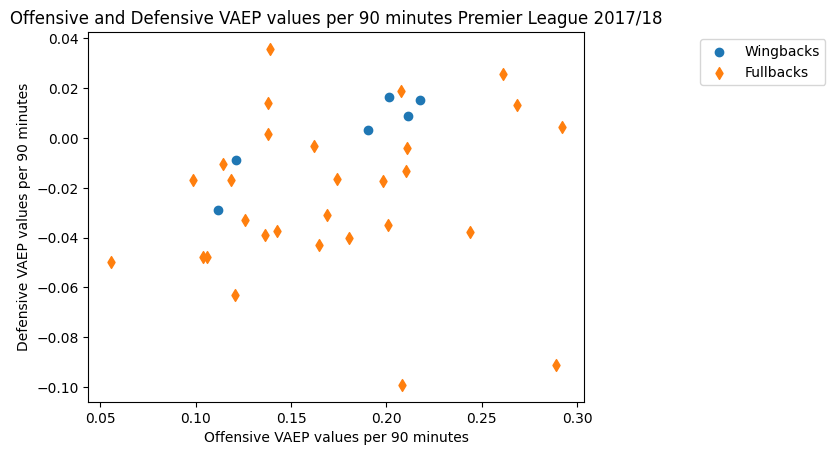

In [58]:
plt.title("Offensive and Defensive VAEP values per 90 minutes Premier League 2017/18")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Defensive VAEP values per 90 minutes")
plt.scatter(Ax, Ay)
plt.scatter(Bx, By, marker="d")
plt.legend(["Wingbacks" , "Fullbacks"], bbox_to_anchor = (1.5 , 1))
plt.show()

In [59]:
#Wingbacks Offensive and Defensive average 

WB_Attacking_avg = WBS["offensive_rating"].mean()

WB_Defending_avg = WBS["defensive_rating"].mean()

WB_Total_avg = WB_Attacking_avg + WB_Defending_avg

In [60]:
WB_Defending_avg

0.0010500000000000012

In [61]:
WB_Attacking_avg

0.17554999999999998

In [62]:
WB_Total_avg

0.17659999999999998

In [63]:
#Fullbacks Offensive and Defensive average 

FB_Attacking_avg = FBS["offensive_rating"].mean()
FB_Defending_avg = FBS["defensive_rating"].mean()
FB_Total_avg = FB_Attacking_avg + FB_Defending_avg

In [64]:
FB_Attacking_avg

0.1716689655172414

In [65]:
FB_Defending_avg

-0.02342068965517241

In [66]:
FB_Total_avg

0.14824827586206898

In [67]:
from prettytable import PrettyTable

# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Player position", "Total", "Offensive", "Defensive"])

# Add rows
myTable.add_row(["fullback", FB_Total_avg,FB_Attacking_avg,FB_Defending_avg])
myTable.add_row(["wingback", WB_Total_avg,WB_Attacking_avg,WB_Defending_avg])


print(myTable)

+-----------------+---------------------+---------------------+-----------------------+
| Player position |        Total        |      Offensive      |       Defensive       |
+-----------------+---------------------+---------------------+-----------------------+
|     fullback    | 0.14824827586206898 |  0.1716689655172414 |  -0.02342068965517241 |
|     wingback    | 0.17659999999999998 | 0.17554999999999998 | 0.0010500000000000012 |
+-----------------+---------------------+---------------------+-----------------------+


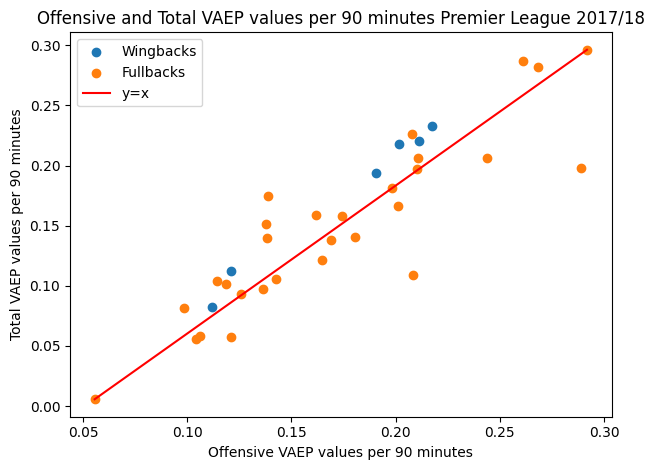

In [68]:
import matplotlib.pyplot as plt

plt.title("Offensive and Total VAEP values per 90 minutes Premier League 2017/18")
plt.xlabel("Offensive VAEP values per 90 minutes") 
plt.ylabel("Total VAEP values per 90 minutes")

plt.scatter(Ax, Az, label='Wingbacks')
plt.scatter(Bx, Bz, label='Fullbacks')

xmin = min(min(Ax), min(Bx))
xmax = max(max(Ax), max(Bx))
ymin = min(min(Az), min(Bz))
ymax = max(max(Az), max(Bz))

plt.plot([xmin, xmax], [ymin, ymax], color='red', label='y=x')

plt.legend(loc='upper left')
plt.tight_layout()
plt.show()